## Montecarlo Simulation
**Edgard Cuadra**

**Ignacio Umpierre**

**Nick Highman**

The following notebook outlines the montecarlo simulation for solar panels given the demand and weather data. 
First we look at the data, and define variables to clean it for easier handling.



In [1]:
# loading the Montecarlo Raw Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
# Load the excel data into a pandas dataframe
df1 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Energy Consumption Raw Data') 
df2 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Daily Temp Average')
df3 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Energy Production')


print(f"We want to look at the columns and some of the data: \n-->This is the  first data frame\n{df1.head()} \n-->This is the second data frame\n{df2.head()} \n-->This is the second data frame\n{df3.head()}")


We want to look at the columns and some of the data: 
-->This is the  first data frame
        Date  Avg Temp  kWh Delivered to Customer  Month Seasson  \
0 2022-01-01        50                     39.708      1  Winter   
1 2022-01-02        47                     31.517      1  Winter   
2 2022-01-03        27                     39.497      1  Winter   
3 2022-01-04        24                     41.692      1  Winter   
4 2022-01-05        31                     34.216      1  Winter   

   hours of light  
0        9.380556  
1        9.393056  
2        9.406667  
3        9.421111  
4        9.436667   
-->This is the second data frame
   Year  2024-01-21 00:00:00
0  2024                19.44
1  2023                35.96
2  2022                15.88
3  2021                29.25
4  2020                24.38 
-->This is the second data frame
        Date  Week Month  hrs of light  Watts_panel_hrlight  Watts produced  \
0 2023-01-01  Wk01   Jan      9.380556            67.328523    

In [3]:
# renaming the 'hours of light column in df1 to hrs of light
df1.rename(columns = {'hours of Light':'hrs of light'}, inplace = True) 
df1.rename(columns = {'Seasson':'Season'}, inplace = True)
print(f"Looking at the columns for the first data frame: \n\t{df1.columns}")
print(f"Looking at the oclumns for the second data frame: \n\t{df2.columns}")
print(f"Looking at the columns for the third data frame: \n\t{df3.columns}")


Looking at the columns for the first data frame: 
	Index(['Date', 'Avg Temp', 'kWh Delivered to Customer', 'Month', 'Season',
       'hours of light'],
      dtype='object')
Looking at the oclumns for the second data frame: 
	Index(['Year', 2024-01-21 00:00:00], dtype='object')
Looking at the columns for the third data frame: 
	Index(['Date', 'Week', 'Month', 'hrs of light', 'Watts_panel_hrlight',
       'Watts produced', 'Season', 'Sun raise angle', 'Sun Dawn Angle',
       'Distance To Sun', 'Sun Angle', 'Weather Coded'],
      dtype='object')


## Data Statistics
We want to look at the data statistics to use later in the data.

In [4]:
# Get statistics from power demand
power_demand_mean = df1['kWh Delivered to Customer'].mean()
power_demand_std = df1['kWh Delivered to Customer'].std()


# get statistics from solar generation
watts_produced_mean = df3['Watts produced'].mean()
watts_produced_std = df3['Watts produced'].std()
solar_generation_mean = df3['Watts_panel_hrlight'].mean()
solar_generation_std = df3['Watts_panel_hrlight'].std()


watts_per_panel_hrlight_mean = df3['Watts_panel_hrlight'].mean()
watts_per_panel_hrlight_std = df3['Watts_panel_hrlight'].std()

# calculating weather variability
weather_variability = df3['Weather Coded'].value_counts(normalize=True).to_dict()

# get hrs_of_light statistics
hrs_of_light_mean = df1['hours of light'].mean()
hrs_of_light_std = df1['hours of light'].std()


print(f'Weather variability: \n{weather_variability}')
print(f'Hours of light mean: {hrs_of_light_mean}, Hours of light std: {hrs_of_light_std}')
print(f'Power demand mean: {power_demand_mean}, Power demand std: {power_demand_std}')
print(f'Watts produced mean: {watts_produced_mean}, Watts produced std: {watts_produced_std}')
print(f'Solar generation mean: {solar_generation_mean}, Solar generation std: {solar_generation_std}')
print(f'Watts per panel per hour of light mean: {watts_per_panel_hrlight_mean}, Watts per panel per hour of light std: {watts_per_panel_hrlight_std}')

Weather variability: 
{'Good': 0.32132963988919666, 'Average': 0.29916897506925205, 'Bad': 0.2631578947368421, 'Extreme Bad': 0.05817174515235457, 'Excellent': 0.05817174515235457}
Hours of light mean: 12.218682648401826, Hours of light std: 1.9910343886540398
Power demand mean: 37.00345479452055, Power demand std: 11.750855324550965
Watts produced mean: 973.6898781503262, Watts produced std: 521.9841339097212
Solar generation mean: 76.74597972459313, Solar generation std: 34.86242004578992
Watts per panel per hour of light mean: 76.74597972459313, Watts per panel per hour of light std: 34.86242004578992


## Montecarlo Setting up

In [5]:
# figuring out the factor for each month
mean_power_per_month = df1.groupby('Month')['kWh Delivered to Customer'].mean()
mean_power_per_month = mean_power_per_month.to_dict()
print(f"This is a dictionary of the month and the average power demand for each month: \n{mean_power_per_month}")

# Need to get the total average for all the months
total_power_demand = df1['kWh Delivered to Customer'].mean()
print(f"Average overall power demand: \n{total_power_demand}")


This is a dictionary of the month and the average power demand for each month: 
{1: 34.9531935483871, 2: 34.827, 3: 36.24677419354839, 4: 32.42856666666667, 5: 35.98170967741935, 6: 29.814733333333333, 7: 54.799741935483866, 8: 53.99070967741935, 9: 41.987899999999996, 10: 34.16309677419355, 11: 28.7148, 12: 25.436548387096774}
Average overall power demand: 
37.00345479452055


**We want to make a factor to incorporate the effect of weather** throughout the different months to the power generation and the demand.

In [6]:
# We need to get a factor from the average power demand for each month
# We will use this factor to scale the power demand for each month
# This will allow us to simulate the power demand for each month
# based on the average power demand for that month
# The factor is the average power demand for each month divided by the overall average power demand
factor_per_month = df1.groupby('Month')['kWh Delivered to Customer'].mean() / total_power_demand
factor_per_month = factor_per_month.to_dict()
print(f"This is the dictionary with the factors: \n{factor_per_month}")

This is the dictionary with the factors: 
{1: 0.9445927074237118, 2: 0.9411823894118437, 3: 0.9795510823199078, 4: 0.8763659189862637, 5: 0.9723878453302556, 6: 0.8057283704695671, 7: 1.4809358272027773, 8: 1.4590721319733169, 9: 1.1347021577622407, 10: 0.9232407342476681, 11: 0.7760032180630894, 12: 0.6874100953098953}


In [7]:
# unique values in the df3['Weather Coded'] column
df3['Weather Coded'].unique()
weather_variability = df3['Weather Coded'].value_counts(normalize=True).to_dict()
print(f"Making a dictionary with the weather condition variabilities: \n{weather_variability}")
weather_multiplier = {
    'Excellent': 1,
    'Good': 0.85,
    'Average': 0.55,
    'Bad': 0.20,
    'Extreme Bad': 0.025,
}
print(f"Assigning a weather multiplier for the weather conditions to factor in the objective equation: \n{weather_multiplier}")

Making a dictionary with the weather condition variabilities: 
{'Good': 0.32132963988919666, 'Average': 0.29916897506925205, 'Bad': 0.2631578947368421, 'Extreme Bad': 0.05817174515235457, 'Excellent': 0.05817174515235457}
Assigning a weather multiplier for the weather conditions to factor in the objective equation: 
{'Excellent': 1, 'Good': 0.85, 'Average': 0.55, 'Bad': 0.2, 'Extreme Bad': 0.025}


In [8]:
# Ensure weather probabilities sum to 1
weather_probabilities = np.array(list(weather_variability.values()))
weather_probabilities /= weather_probabilities.sum()
print(f"Making an array with the weather probabiliies: \n{weather_probabilities}")

Making an array with the weather probabiliies: 
[0.32132964 0.29916898 0.26315789 0.05817175 0.05817175]


## Montecarlo Methodology

In [9]:
# Define simulation parameters
num_simulations = 1000  # Iterations
years = 30  # Time Horizon

# Running the Monte Carlo simulation
net_power_results = []
panel_requirements = []
yearly_panel_distributions = []  # Store panels per year
all_panels = []  # To store the final number of panels needed per simulation

# Scale factor to bring panels to a reasonable range (adjust as needed)
SCALE_FACTOR = 0.1  

for sim in range(num_simulations):
    total_power_needed = 0
    total_solar_produced = 0
    yearly_panels_required = []  # per year panels

    for year in range(years):
        yearly_power_needed = 0
        yearly_solar_produced = 0
        
        for month in range(1, 13):
            # Simulate power demand per month
            base_demand = np.random.normal(power_demand_mean, power_demand_std)
            month_adjusted_demand = base_demand * factor_per_month[month]  
            demand = max(0, month_adjusted_demand)
            yearly_power_needed += demand
            
            # Simulate sunlight hours for the month
            monthly_hrs_of_light = np.random.normal(hrs_of_light_mean, hrs_of_light_std)
            monthly_hrs_of_light = max(0, monthly_hrs_of_light)
            
            # Panel efficiency
            panel_efficiency = np.random.normal(watts_per_panel_hrlight_mean, watts_per_panel_hrlight_std)
            panel_efficiency = max(0, panel_efficiency)

            # Simulate weather effect
            weather_effect = np.random.choice(list(weather_variability.keys()), p=list(weather_variability.values()))
            weather_base = weather_multiplier[weather_effect]
            weather_multiplier_effect = max(0.1, min(1.2, weather_base * np.random.normal(1, 0.08)))
            
            # Option 1: Scale the panel efficiency up (this simulates more efficient panels)
            scaled_panel_efficiency = panel_efficiency / SCALE_FACTOR
            
            # Compute monthly energy production per panel (in kWh)
            monthly_panel_production = (scaled_panel_efficiency * monthly_hrs_of_light * weather_multiplier_effect * factor_per_month[month]) / 1000
            
            # Option 2 could scale down to the power needed
            # scaled_demand = demand * SCALE_FACTOR
            # yearly_power_needed += scaled_demand
            
            yearly_solar_produced += monthly_panel_production

        # Calculate panels needed for this year
        if yearly_power_needed > 0 and yearly_solar_produced > 0:
            # Calculate raw panel needs without ceiling yet
            raw_panels_needed = (yearly_power_needed * 1.1) / yearly_solar_produced
            
            # Add installation factors for variability
            installation_factor = np.random.normal(1, 0.15)
            
            # Calculate final panel count
            panels_needed = max(1, np.ceil(raw_panels_needed * installation_factor))
            
            # Option 3 Directly scale the final panel count
            # panels_needed = max(1, np.ceil(raw_panels_needed * installation_factor * SCALE_FACTOR))
        else:
            panels_needed = 1
            
        yearly_panels_required.append(panels_needed)
    
    # Using a weighted approach for final panel count
    sorted_yearly = np.sort(yearly_panels_required)
    if len(sorted_yearly) > 0:
        percentile_90 = sorted_yearly[min(int(0.9 * len(sorted_yearly)), len(sorted_yearly)-1)]
        percentile_75 = sorted_yearly[min(int(0.75 * len(sorted_yearly)), len(sorted_yearly)-1)]
    else:
        percentile_90 = percentile_75 = 1
    
    weighted_panel_count = (0.5 * max(yearly_panels_required) + 0.3 * percentile_90 + 0.2 * percentile_75)
    
    # Add final variability factors
    final_variability = np.random.normal(1, 0.12)
    final_panel_count = max(1, np.ceil(weighted_panel_count * final_variability))
    
    all_panels.append(final_panel_count)
    yearly_panel_distributions.append(yearly_panels_required)

# Convert to numpy arrays for easier analysis
all_panels = np.array(all_panels)
yearly_panel_distributions = np.array(yearly_panel_distributions)

*Note that simulation runs differ from simulation runs, so the mean in this file is different from the report

Mean panels required: 14.01
Median panels required: 14.00
Standard deviation: 2.33
Min panels required: 7.0
Max panels required: 25.0
90th percentile: 17.0
Estimated 95% Confidence Interval: 10.00 - 19.00
Estimated panel requirement for 95% of simulations: 11.00


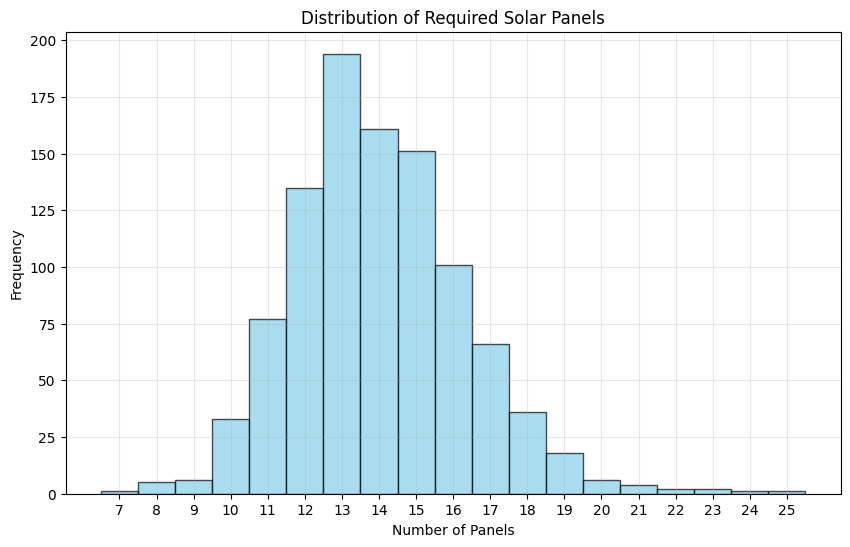

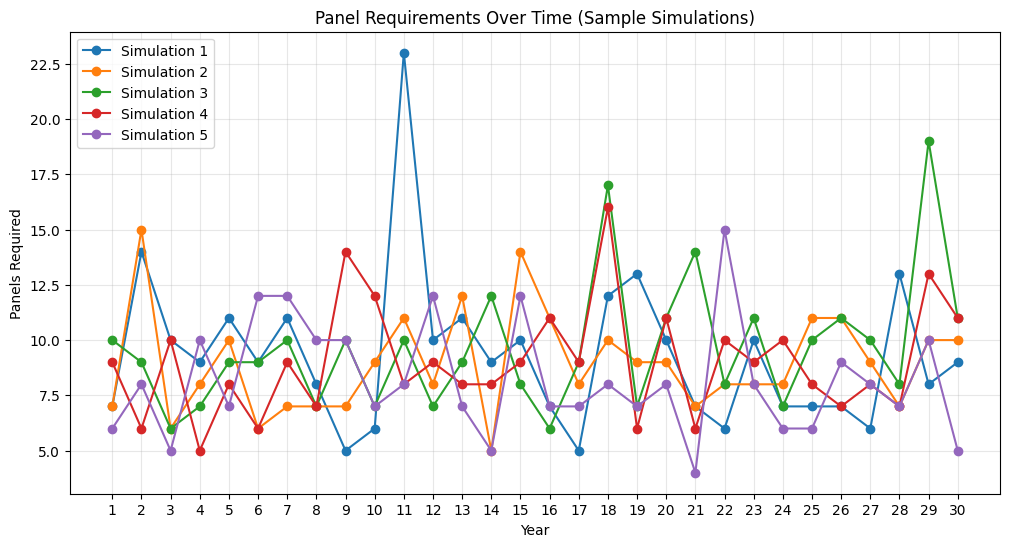

In [ ]:
# Now you can analyze the distribution of panel requirements
print(f"Mean panels required: {np.mean(all_panels):.2f}")
print(f"Median panels required: {np.median(all_panels):.2f}")
print(f"Standard deviation: {np.std(all_panels):.2f}")
print(f"Min panels required: {np.min(all_panels)}")
print(f"Max panels required: {np.max(all_panels)}")
print(f"90th percentile: {np.percentile(all_panels, 90)}")
print(f'Estimated 95% Confidence Interval: {np.percentile(all_panels,2.5):.2f} - {np.percentile(all_panels,97.5):.2f}')
print(f'Estimated panel requirement for 95% of simulations: {np.percentile(all_panels,95):.2f}')
# Define bin edges to be at integer values
min_panels = int(min(all_panels))
max_panels = int(max(all_panels))
bins = np.arange(min_panels - 0.5, max_panels + 1.5, 1)  # Centers bins on integers

# Plot the histogram with integer bins
plt.figure(figsize=(10, 6))
plt.hist(all_panels, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
plt.xticks(np.arange(min_panels, max_panels + 1, 1))  # Ensure x-axis ticks are at integer positions
plt.title('Distribution of Required Solar Panels')
plt.xlabel('Number of Panels')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig('panel_distribution.png')
plt.show()

# Visualize yearly panel requirement over time for a few simulations
plt.figure(figsize=(12, 6))
for i in range(5):  # Show 5 sample simulation paths
    plt.plot(range(1, years + 1), yearly_panel_distributions[i], marker='o', linestyle='-',
             label=f'Simulation {i+1}')  # Add markers for clarity
plt.xticks(np.arange(1, years + 1, 1))  # Ensure x-axis increments by 1
plt.title('Panel Requirements Over Time (Sample Simulations)')
plt.xlabel('Year')
plt.ylabel('Panels Required')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('panel_requirements_over_time.png')
plt.show()